In [217]:
import SimpleITK as sitk
import os
import pandas as pd
import numpy as np
import time
import sys
import pydicom
import shutil
%matplotlib inline
import matplotlib.pyplot as plt

In [289]:
paths = [['temp/dicoms/in', 'temp/dicoms/out', 'temp/dicoms/fat', 'temp/dicoms/water'], ['temp/dicoms/b50', 'temp/dicoms/b900', 'temp/dicoms/adc']]
series_numbers = [[1, 2, 3, 4], [5, 7, 8]]
series_descriptons=  [['in', 'out', 'fat', 'water'], ['b50', 'b900', 'ADC']]

In [26]:
df = pd.read_csv('df.csv')

In [84]:
def load_sitk_image_volumes(paths, series_descriptions):
    imgs = []
    readers = []
    print('--- Loading Image Volumes in SimpleITK ---')
    for g, group in enumerate(paths):
        imgs.append([])
        readers.append([])
        for i, path in enumerate(group):
            for dirName, subdirList, fileList in os.walk(path):
                verbose_path = list(set([dirName for filename in fileList if filename.lower().endswith('.dcm')]))
                if len(verbose_path):  # this code is pretty gross but it works
                    print('"' + series_descriptions[g][i] + '"', 'image volume loaded')
                    reader = sitk.ImageSeriesReader()
                    dcm_names = reader.GetGDCMSeriesFileNames(verbose_path[0])
                    reader.SetFileNames(dcm_names)
                    reader.MetaDataDictionaryArrayUpdateOn()
                    reader.LoadPrivateTagsOn()
                    imgs[g].append(reader.Execute())
                    readers[g].append(reader)
    return imgs, readers

In [259]:
imgs, readers = load_sitk_image_volumes(paths, series_descriptons)

--- Loading Image Volumes in SimpleITK ---
"In Phase" image volume loaded
"Out of Phase" image volume loaded
"Fat" image volume loaded
"Water" image volume loaded
"b50" image volume loaded
"b900" image volume loaded
"ADC" image volume loaded


In [94]:
def myshow2(imgs, titles):
    n_col = max([len(group) for group in imgs])
    n_row = len(imgs)
    fig, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
    fig.set_dpi(100)
    # fig.set_size_inches(20,6)
    for g, group in enumerate(imgs):
        i = 0
        for img, ax in (zip(group, axs[g])):
            spacing = img.GetSpacing()
            x_space = spacing[0]
            z_space = spacing[2]
            y = int(img.GetHeight()/1.7)
            nda_y = sitk.GetArrayViewFromImage(img)[:,y,:]
            x_size = nda_y.shape[1]
            z_size = nda_y.shape[0]
            extent = (0, x_size*x_space, z_size*z_space, 0)
            ax.set_title(titles[g][i])
            t = ax.imshow(nda_y,extent=extent,interpolation=None, origin='lower', 
                  cmap='Greys_r', vmin=nda_y.min(), vmax=nda_y.max()/2)
            i += 1
    fig.savefig("scans.pdf", bbox_inches='tight')
    for ax in axs.flatten():
        if not ax.images:
            ax.axis('off')

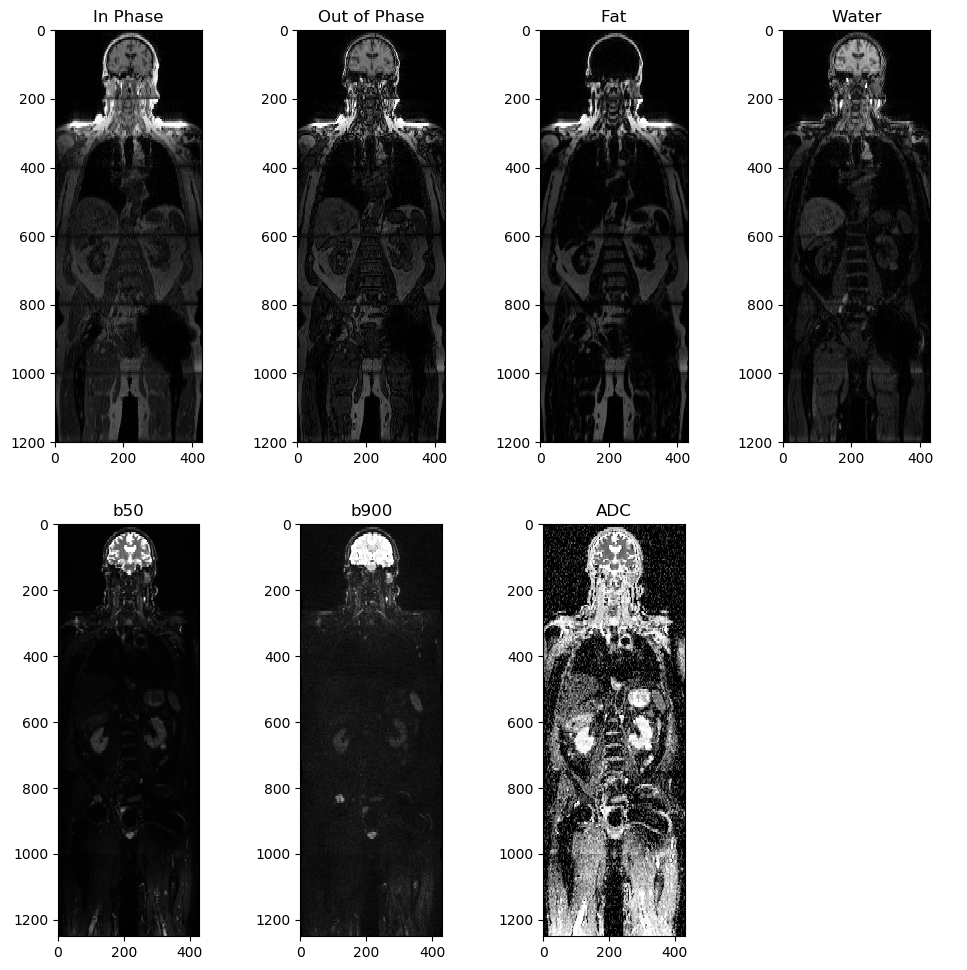

In [95]:
myshow2(imgs, series_descriptons)

In [ ]:
[[f(x) for x in y] for 

In [157]:
imgs

[[<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x12ee65f30> >,
  <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x12ee65120> >,
  <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x12ee65ea0> >,
  <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x152f9cae0> >],
 [<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x152f9cf60> >,
  <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x152f9cb70> >,
  <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x152f9c6c0> >]]

In [159]:
for group in imgs:
    print(group)

[<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x12ee65f30> >, <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x12ee65120> >, <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x12ee65ea0> >, <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x152f9cae0> >]
[<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x152f9cf60> >, <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x152f9cb70> >, <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x152f9c6c0> >]


In [96]:
def match_fovs_2(image_volumes, series_descriptons):
    imgs = [img for group in image_volumes for img in group]  # flattens nested list
    origin = tuple(np.max([img.GetOrigin()[i] for img in imgs]) for i in range(3))
    fov = tuple(np.min([img.GetSize()[i]*img.GetSpacing()[i] for img in imgs]) for i in range(3))
    directions = [img.GetDirection() for img in imgs]
    direction = max(set(directions), key = directions.count)

    imgs_new = []

    for g, group in enumerate(image_volumes):
        spacings = [img.GetSpacing() for img in group]
        ref_spacing = max(set(spacings), key = spacings.count)

        ref_size = tuple(int(round(fov/spacing, 0)) for fov, spacing in zip(fov, ref_spacing))

        resample = sitk.ResampleImageFilter()
        resample.SetOutputSpacing(ref_spacing)
        resample.SetSize(ref_size)
        resample.SetOutputDirection(direction)
        resample.SetOutputOrigin(origin)
        resample.SetTransform(sitk.Transform())
        resample.SetDefaultPixelValue(3)
        resample.SetInterpolator(sitk.sitkLinear)
        
        print('Resampling Image Volumes:')
        imgs_new.append([resample.Execute(img) for img in group])
        
        for i, img in enumerate(group):
            print('-------',series_descriptons[g][i],'-------')
            print('Origin:', img.GetOrigin(), '---->', origin)
            print('Direction:', img.GetDirection(), '---->', direction)
            print('Spacing:', img.GetSpacing(), '---->', ref_spacing)
            print('FOV:', tuple(sp*si for sp, si in zip(img.GetSpacing(), img.GetSize())), 
                  '---->', fov)
            print('Size:', img.GetSize(), '---->', ref_size)
            
    return imgs_new

In [97]:
imgs_new_2 = match_fovs_2(imgs, series_descriptons)

Resampling Image Volumes:
------- In Phase -------
Origin: (-209.9216766357422, -230.06927490234375, -997.5) ----> (-209.92166137695312, -227.38177490234375, -997.5)
Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0) ----> (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Spacing: (0.83984375, 0.83984375, 5.0) ----> (0.83984375, 0.83984375, 5.0)
FOV: (430.0, 349.375, 1200.0) ----> (429.999995231632, 343.99999618530563, 1200.0)
Size: (512, 416, 240) ----> (512, 410, 240)
------- Out of Phase -------
Origin: (-209.9216766357422, -230.06927490234375, -997.5) ----> (-209.92166137695312, -227.38177490234375, -997.5)
Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0) ----> (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Spacing: (0.83984375, 0.83984375, 5.0) ----> (0.83984375, 0.83984375, 5.0)
FOV: (430.0, 349.375, 1200.0) ----> (429.999995231632, 343.99999618530563, 1200.0)
Size: (512, 416, 240) ----> (512, 410, 240)
------- Fat -------
Origin: (-209.9216766357422, -230.06927490234375

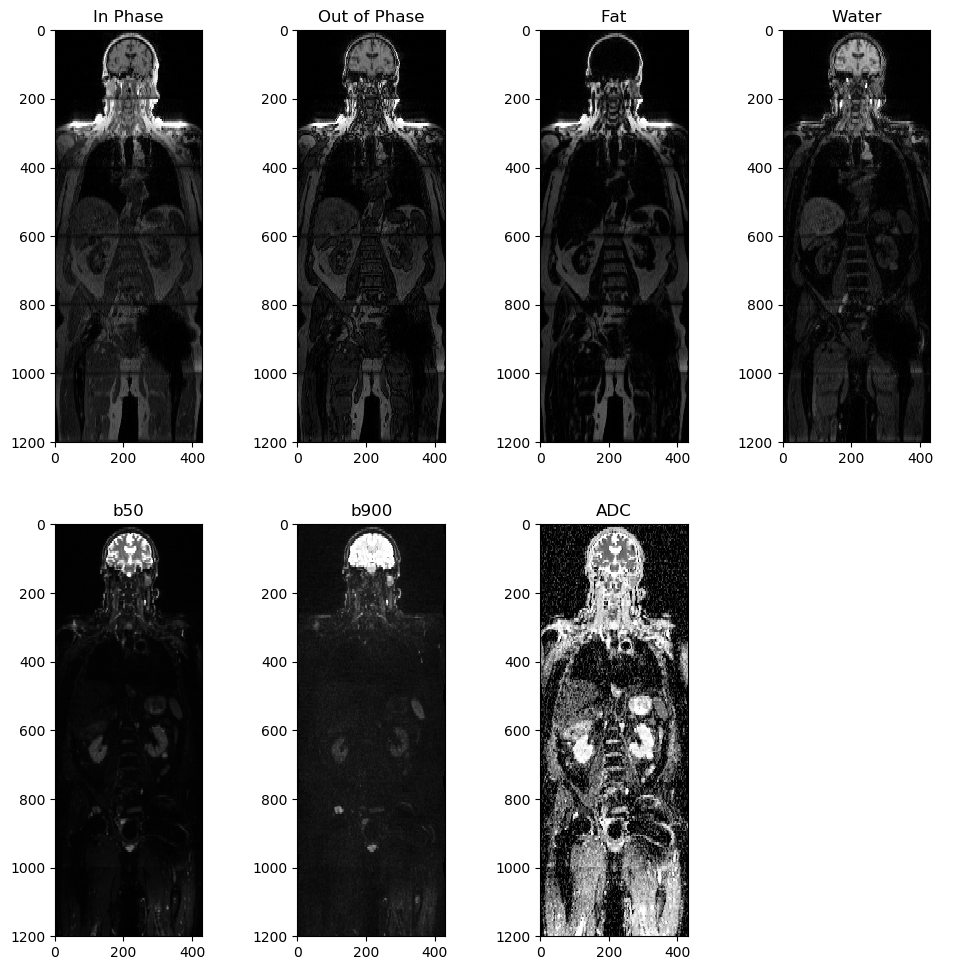

In [98]:
myshow2(imgs_new_2, series_descriptons)

In [ ]:
{'Patients Birth Date': '0010|0030'}

In [ ]:
series_tags_to_change = {}

In [ ]:
slice_tags_to_change = {}

In [312]:
def write_sitk_image_volumes(imgs, readers, series_descriptons, series_numbers):
    print('--- Writing DICOM Series from SimpleITK ---')
    shutil.rmtree('temp/dicoms_new', ignore_errors=True)
    os.mkdir('temp/dicoms_new')
    for g, group in enumerate(imgs):
        for i, img in enumerate(group):
            reader = readers[g][i]
            series_description = series_descriptons[g][i]
            series_number = series_numbers[g][i]

            os.mkdir(os.path.join('temp/dicoms_new/',series_description))

            writer = sitk.ImageFileWriter()
            writer.KeepOriginalImageUIDOn()

            tags_to_copy = ["0010|0010", # Patient Name
                            "0010|0020", # Patient ID
                            "0010|0030", # Patient Birth Date
                            "0010|0040", # Patient Sex
                            "0010|4000", # Patient Comments
                            "0020|000D", # Study Instance UID, for machine consumption
                            "0020|0010", # Study ID, for human consumption
                            "0008|0020", # Study Date
                            "0008|0030", # Study Time
                            "0008|0050", # Accession Number
                            "0008|0060", # Modality
                            "0018|5100"  # Patient Position
                           ]

            modification_time = time.strftime("%H%M%S")
            modification_date = time.strftime("%Y%m%d")

            direction = img.GetDirection()
            slice_thickness = str(img.GetSpacing()[2])

            series_tag_values = [(k, reader.GetMetaData(0,k)) for k in tags_to_copy if reader.HasMetaDataKey(0,k)] + \
                         [("0008|0031",modification_time), # Series Time
                          ("0008|0021",modification_date), # Series Date
                          ("0020|0037", '\\'.join(map(str, (direction[0], direction[3], direction[6],# Image Orientation (Patient)
                                                            direction[1],direction[4],direction[7])))),
                          ("0008|103e", series_description), # Series Description
                          ('0020|0011', str(series_number)), # Series Number
                          ("0008|0008","DERIVED\\SECONDARY"), # Image Type
                          ("0020|000e", pydicom.uid.generate_uid(prefix='1.2.826.0.1.3680043.8.498.')), # Series Instance UID
                         ]
            for i in range(img.GetDepth()):
                image_slice = img[:,:,i]
                # Tags shared by the series.
                for tag, value in series_tag_values:
                    # print(tag)
                    image_slice.SetMetaData(tag, value)

                j = img.GetDepth() - i
                # Slice specific tags.
                image_slice.SetMetaData("0008|0012", time.strftime("%Y%m%d")) # Instance Creation Date
                image_slice.SetMetaData("0008|0013", time.strftime("%H%M%S")) # Instance Creation Time
                image_slice.SetMetaData("0020|0032", '\\'.join(map(str,img.TransformIndexToPhysicalPoint((0,0,i))))) # Image Position (Patient)
                image_slice.SetMetaData("0020|0013", str(j)) # Instance Number
                image_slice.SetMetaData("0018|0050", slice_thickness)
                image_slice.SetMetaData("0008|0018", pydicom.uid.generate_uid(prefix='1.2.826.0.1.3680043.8.498.'))

                # Write to the output directory and add the extension dcm, to force writing in DICOM format.

                writer.SetFileName(os.path.join('temp/dicoms_new',series_description, str(j)+'.dcm'))
                writer.Execute(image_slice)
            print('"' + series_description + '"', 'image volume saved')

need new SOPInstanceUID and SeriesInstanceUID

In [313]:
type(str(series_numbers[0][0]))

str

In [314]:
write_sitk_image_volumes(imgs_new_2, readers, series_descriptons, series_numbers)

--- Writing DICOM Series from SimpleITK ---
"in" image volume saved
"out" image volume saved
"fat" image volume saved
"water" image volume saved
"b50" image volume saved
"b900" image volume saved
"ADC" image volume saved


In [179]:
import gc
gc.collect()

9475

In [273]:
# [(k, reader.GetMetaData(1,k)) for k in reader.GetMetaDataKeys(1) if reader.HasMetaDataKey(1,k)]

[('0008|0008', 'ORIGINAL\\PRIMARY\\M\\DIS2D'),
 ('0008|0012', '20170720'),
 ('0008|0013', '151813.015000 '),
 ('0008|0016', '1.2.840.10008.5.1.4.1.1.4'),
 ('0008|0018', '1.3.12.2.1107.5.2.30.26049.30000017072014472429600000997'),
 ('0008|0020', '20170720'),
 ('0008|0021', '20170720'),
 ('0008|0022', '20170720'),
 ('0008|0023', '20170720'),
 ('0008|0030', '140915'),
 ('0008|0031', '155007.781000 '),
 ('0008|0032', '151746.832500 '),
 ('0008|0033', '155007.718000 '),
 ('0008|0060', 'MR'),
 ('0008|0070', 'SIEMENS '),
 ('0008|103e', 'axial in'),
 ('0008|1090', 'Avanto'),
 ('0010|0010', 'RMH4820_069 '),
 ('0010|0020', '212DEJO '),
 ('0010|0030', '19010101'),
 ('0010|0040', 'M '),
 ('0010|4000',
  'Project: MALIMAR_ALL; Subject: RMH4820_069; Session: 20170720_140915_Avanto; AA:true'),
 ('0012|0062', 'YES '),
 ('0012|0063', 'DicomEdit 4 anonymisation script'),
 ('0018|0020', 'GR'),
 ('0018|0021', 'SP'),
 ('0018|0022', 'PFP '),
 ('0018|0023', '3D'),
 ('0018|0024', '*fl3d2'),
 ('0018|0025', 'N 

In [270]:
# for k in reader.GetMetaDataKeys(1):
#     v = reader.GetMetaData(1, k)
#     print("({0}) = = \"{1}\"".format(k,v))

(0008|0008) = = "ORIGINAL\PRIMARY\M\DIS2D"
(0008|0012) = = "20170720"
(0008|0013) = = "151813.015000 "
(0008|0016) = = "1.2.840.10008.5.1.4.1.1.4"
(0008|0018) = = "1.3.12.2.1107.5.2.30.26049.30000017072014472429600000997"
(0008|0020) = = "20170720"
(0008|0021) = = "20170720"
(0008|0022) = = "20170720"
(0008|0023) = = "20170720"
(0008|0030) = = "140915"
(0008|0031) = = "155007.781000 "
(0008|0032) = = "151746.832500 "
(0008|0033) = = "155007.718000 "
(0008|0060) = = "MR"
(0008|0070) = = "SIEMENS "
(0008|103e) = = "axial in"
(0008|1090) = = "Avanto"
(0010|0010) = = "RMH4820_069 "
(0010|0020) = = "212DEJO "
(0010|0030) = = "19010101"
(0010|0040) = = "M "
(0010|4000) = = "Project: MALIMAR_ALL; Subject: RMH4820_069; Session: 20170720_140915_Avanto; AA:true"
(0012|0062) = = "YES "
(0012|0063) = = "DicomEdit 4 anonymisation script"
(0018|0020) = = "GR"
(0018|0021) = = "SP"
(0018|0022) = = "PFP "
(0018|0023) = = "3D"
(0018|0024) = = "*fl3d2"
(0018|0025) = = "N "
(0018|0050) = = "5 "
(0018|0080

In [ ]:
# def myshow(img, margin=0.05, dpi=80):
#     spacing = img.GetSpacing()
#     x_space = spacing[0]
#     z_space = spacing[2]
#     y = int(img.GetHeight()/2)
#     nda_y = sitk.GetArrayViewFromImage(img)[:,y,:]
#     x_size = nda_y.shape[1]
#     z_size = nda_y.shape[0]
#     figsize = (1 + margin) * z_size / dpi, (1 + margin) * x_size / dpi
#     figsize = 20, 6
#     fig = plt.figure(figsize=figsize, dpi=dpi)
#     ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
#     extent = (0, x_size*x_space, z_size*z_space, 0)
#     t = ax.imshow(nda_y,extent=extent,interpolation=None, origin='lower', 
#                   cmap='Greys_r', vmin=nda_y.min(), vmax=nda_y.max()/2)

In [8]:
# image_volumes = []
# for g, group in enumerate(paths):
#     image_volumes.append([])
#     for i, path in enumerate(group):
#         for dirName, subdirList, fileList in os.walk(path):
#             verbose_path = list(set([dirName for filename in fileList if filename.lower().endswith('.dcm')]))
#             if len(verbose_path):  # this code is pretty gross but it works
#                 print('"'+series_descriptons[g][i]+'"', 'image volume loaded')
#                 reader = sitk.ImageSeriesReader()
#                 dcm_names = reader.GetGDCMSeriesFileNames(verbose_path[0])
#                 reader.SetFileNames(dcm_names)
#                 image_volumes[g].append(reader.Execute())

"In Phase" image volume loaded
"Out of Phase" image volume loaded
"Fat" image volume loaded
"Water" image volume loaded
"b50" image volume loaded
"b900" image volume loaded
"ADC" image volume loaded


In [ ]:
# def get_reference_img(imgs):
#     # needs to be a reference group and a reference series in each group
#     # intragroup reference defines origin, FOV and slice spacing
#     # intergroup reference defines in-plane resolution for each group
    
#     avg_num_pixels = []
#     ref_series = []
#     for group in imgs:
#         # for reference group: 
#         num_pixels = [img.GetWidth()*img.GetHeight() for img in group]
#         avg_num_pixels.append(int(np.mean(num_pixels)))
#         # intra group reference, decided by most common FOV:
#         fovs = [tuple(sp*si for sp, si in zip(img.GetSpacing(), img.GetSize())) for img in group]
#         ref_fov = max(set(fovs), key = fovs.count)
#         ref_series.append(fovs.index(ref_fov))
#     # Choose the reference group based on which group has the highest mean in-plane size
#     ref_group = np.argmin(avg_num_pixels)
#     return ref_group, ref_series

In [ ]:
# fov1 = tuple(sp*si for sp, si in zip(image_volumes[0][1].GetSpacing(), image_volumes[0][1].GetSize()))
# fov2 = tuple(sp*si for sp, si in zip(image_volumes[1][1].GetSpacing(), image_volumes[1][1].GetSize()))
# print(fov1)
# print(fov2)

In [ ]:
# The problem with this method is that it loads the series in the same order as the order of the
# file name list, which means the slices are in completely the wrong spatial order....

# image_volumes = []
# for g, group in enumerate(paths):
#     image_volumes.append([])
#     for i, path in enumerate(group):
#         for dirName, subdirList, fileList in os.walk(path):
#             dcm_names = [os.path.join(dirName, filename) for filename in fileList if filename.lower().endswith('.dcm')]
#             if len(dcm_names):
#                 reader = sitk.ImageSeriesReader()
#                 reader.SetImageIO('GDCMImageIO')
#                 reader.SetFileNames(dcm_names)
#                 image_volumes[g].append(reader.Execute())

In [ ]:
# def resample_img(img, ref):
#     fov_ref = tuple(sp*si for sp, si in zip(ref.GetSpacing(), ref.GetSize()))
#     size_new = tuple(int(fov/size) for fov, size in zip(fov_ref, img.GetSpacing()))
    
#     resample = sitk.ResampleImageFilter()
#     resample.SetOutputSpacing(img.GetSpacing())
#     resample.SetSize(size_new)
#     resample.SetOutputDirection(ref.GetDirection())
#     resample.SetOutputOrigin(ref.GetOrigin())
#     resample.SetTransform(sitk.Transform())
#     resample.SetDefaultPixelValue(ref.GetPixelIDValue())
#     resample.SetInterpolator(sitk.sitkLinear)
    
#     return resample.Execute(img)

In [ ]:
# def get_reference_parameters(imgs):
#     # Choose the reference group based on which one has the highest in-plane size
#     avg_num_pixels = []
#     for g, group in enumerate(imgs):
#         num_pixels = [img.GetWidth()*img.GetHeight() for img in group]
#         avg_num_pixels.append(int(np.mean(num_pixels)))
#     ref_group = np.argmin(avg_num_pixels)
    
#     # Get reference in-plane spacing for each group, decided by the most common spacing  in each group
    
#     ref_spacing = []
#     for group in imgs:
#         spacing = [img.GetSpacing() for img in group]
#         ref_spacing.append(list(max(set(spacing), key = spacing.count)))
        
#     # Set slice thicknesses (depth) to equal that of reference group
#     return ref_spacing

In [ ]:
# def match_fovs_2(image_volumes):
#     imgs = [img for group in image_volumes for img in group]  # flattens nested list
#     origin = tuple(np.max([img.GetOrigin()[i] for img in imgs]) for i in range(3))
#     print('origin =', origin)
#     fov = tuple(np.min([img.GetSize()[i]*img.GetSpacing()[i] for img in imgs]) for i in range(3))
#     print('fov =', fov)
#     directions = [img.GetDirection() for img in imgs]
#     direction = max(set(directions), key = directions.count)
#     print('direction =',direction)

#     imgs_new = []

#     for group in image_volumes:
#         spacings = [img.GetSpacing() for img in group]
#         ref_spacing = max(set(spacings), key = spacings.count)
#         print('spacing = ', ref_spacing)

#         ref_size = tuple(int(round(fov/spacing, 0)) for fov, spacing in zip(fov, ref_spacing))
#         print('size =', ref_size)

#         resample = sitk.ResampleImageFilter()
#         resample.SetOutputSpacing(ref_spacing)
#         resample.SetSize(ref_size)
#         resample.SetOutputDirection(direction)
#         resample.SetOutputOrigin(origin)
#         resample.SetTransform(sitk.Transform())
#         resample.SetDefaultPixelValue(3)
#         resample.SetInterpolator(sitk.sitkLinear)

#         imgs_new.append([resample.Execute(img) for img in group])
        
#     return imgs_new

In [ ]:
# imgs = [img for group in image_volumes for img in group]  # flattens nested list 
# mins = [np.max([img.GetOrigin()[i] for img in imgs]) for i in range(3)]
# maxs = [mins[i] + np.min([img.GetSize()[i]*img.GetSpacing()[i] for img in imgs]) for i in range(3)]

In [ ]:
# def match_fovs(imgs):
#     # This method takes the FOV from the reference group, which is the one with the fewest voxels
#     # to reduce computational cost.
#     # but this has been superseeded by an algorithm that takes the 3D physical union of all the FOVs 
    
#     # needs to be a reference group and a reference series in each group
#     # intergroup reference defines origin, FOV and slice spacing
#     # intragroup reference defines in-plane resolution for each group
#     avg_num_pixels = []
#     ref_series = []
#     for group in imgs:
#         # for reference group: 
#         num_pixels = [img.GetWidth()*img.GetHeight() for img in group]
#         # could of also used img.GetNumberOfPixels()
#         avg_num_pixels.append(int(np.mean(num_pixels)))
#         # intra group reference, decided by most common FOV:
#         fovs = [tuple(sp*si for sp, si in zip(img.GetSpacing(), img.GetSize())) for img in group]
#         ref_fov = max(set(fovs), key = fovs.count)
#         ref_series.append(fovs.index(ref_fov))
#     # Choose the reference group based on which group has the highest mean in-plane size
#     ref_group = np.argmax(avg_num_pixels)
#     print('Reference Group = ', ref_group)
#     print('Reference Series = ', ref_series)
#     inter_ref = imgs[ref_group][ref_series[ref_group]]    
#     fov_ref = tuple(sp*si for sp, si in zip(inter_ref.GetSpacing(), inter_ref.GetSize()))
        
#     imgs_new = []
#     for g, group in enumerate(imgs):
#         intra_ref = group[ref_series[g]]
#         size_new = tuple(int(fov/size) for fov, size in zip(fov_ref, intra_ref.GetSpacing()))
#         print(size_new)
        
#         resample = sitk.ResampleImageFilter()
#         resample.SetOutputSpacing(intra_ref.GetSpacing())
#         resample.SetSize(size_new)
#         resample.SetOutputDirection(inter_ref.GetDirection())
#         resample.SetOutputOrigin(inter_ref.GetOrigin())
#         resample.SetTransform(sitk.Transform())
#         resample.SetDefaultPixelValue(intra_ref.GetPixelIDValue())
#         resample.SetInterpolator(sitk.sitkLinear)
        
#         imgs_new.append([resample.Execute(img) for img in group])
    
#     return imgs_new

In [160]:
A = [[[1, 2],[3, 4]],[[5, 6],[7, 8]]]

In [171]:
l = [elem for row in A for elem in row]

In [174]:
[item for col in [elem for row in A for elem in row] for item in col]

[1, 2, 3, 4, 5, 6, 7, 8]

In [176]:
a = sitk.GetArrayFromImage(img)
type(a)

numpy.ndarray

In [178]:
a.flatten()

array([0, 0, 0, ..., 0, 0, 0], dtype=uint16)

In [125]:
A = [1, 2, 3, 4, 5]
B = [6, 7, 8, 9, 10]

In [154]:
for i in range(len(A)):
    if A[i] == 2:
        print(B[i])

7


In [156]:
[B[i] for i in range(len(A)) if A[i] == 2]

[7]